# 목차
## Step 1. 실험환경 Set-up
## Step 2. 데이터 준비하기
## Step 3. 데이터 시각화
## Step 4. CNN 모델링
## Step 5. 데이터 imbalance 처리
## Step 6. 모델 훈련
## Step 7. 결과 확인과 시각화

In [1]:
import re    # 정규표현식 관련된 작업에 필요한 패키지
import os    # I/O 관련된 작업에 필요한 패키지 
import pandas as pd     # 데이터 전처리 관련된 작업에 필요한 패키지
import numpy as np      # 데이터 array 작업에 필요한 패키지
import tensorflow as tf  # 딥러닝 관련된 작업에 필요한 패키지
import matplotlib.pyplot as plt    # 데이터 시각화에 관련된 작업에 필요한 패키지
from sklearn.model_selection import train_test_split  # 데이터 전처리에 필요한 패키지

In [2]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE

# 데이터 ROOT 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')

# BATCH_SIZE 변수
BATCH_SIZE = 16

# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# EPOCH 크기 변수
EPOCHS = 20

print(ROOT_PATH)

/home/aiffel-dj62/aiffel


### 데이터 불러오기
* glob로 폴더 안의 모든 이미지 추출

In [3]:
train_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/train/*/*'))
test_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/test/*/*'))
val_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/val/*/*'))

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


### 갯수가 너무 부족하기 때문에 train data 일부를 val set에 추가
* [a, b, c], [d, e]가 있을 때
* append: list에 요소로 추가
  * e.g. [a, b, c, [d, e]]
* extend: list끼리 결합
  * e.g. [a, b, c, d, e]

In [4]:
filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/train/*/*'))# 파일명 불러오기
# print(filenames)
filenames.extend(tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/val/*/*')))# 두 디렉토리의 파일명 결합

# train, test(val) dataset으로 분할. test_size의 0.2는 20%를 의미함.
train_filenames, val_filenames = train_test_split(filenames, test_size=0.2, random_state = 1000)

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [5]:
# filename에 NORMAL이 있으면 filename을 리스트에 추가
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print("Normal images count in training set: " + str(COUNT_NORMAL))

COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print("Pneumonia images count in training set: " + str(COUNT_PNEUMONIA))

Normal images count in training set: 1083
Pneumonia images count in training set: 3102


### tf.data 인스턴스 생성
* tf.data는 tensorflow에서 학습시킬 때, 배치처리 작업을 보다 효율적으로 만들어줌
  * tf.data.Dataset.from_tensor_slices 함수는 tf.data.Dataset 를 생성하는 함수로 입력된 텐서로부터 slices를 생성합니다. 예를 들어 MNIST의 학습데이터 (60000, 28, 28)가 입력되면, 60000개의 slices로 만들고 각각의 slice는 28×28의 이미지 크기를 갖게 됩니다.

In [6]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

### Train 데이터 셋, validation 데이터 셋 갯수 확인
* tf.data.experimental.cardinality는 데이터셋의 cardinality를 반환함 
  * 중복도가 ‘낮으면’ cardinality가 ‘높다’고 표현
  * 중복도가 ‘높으면’ cardinality가 ‘낮다’고 표현

In [7]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print("Training images count: " + str(TRAIN_IMG_COUNT))

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print("Validating images count: " + str(VAL_IMG_COUNT))

Training images count: 4185
Validating images count: 1047


### 라벨명 확인

In [8]:
tf.strings.split('/home/aiffel-dj62/aiffel/chest_xray/train/PNEUMONIA', os.path.sep)

<tf.Tensor: shape=(7,), dtype=string, numpy=
array([b'', b'home', b'aiffel-dj62', b'aiffel', b'chest_xray', b'train',
       b'PNEUMONIA'], dtype=object)>

In [9]:
a = np.array([str(tf.strings.split('/home/aiffel-dj62/aiffel/chest_xray/train/PNEUMONIA', os.path.sep)[-1].numpy())])
print(a)

["b'PNEUMONIA'"]


In [10]:
([tf.strings.split('/home/aiffel-dj62/aiffel/chest_xray/train/PNEUMONIA', os.path.sep)[-1].numpy()])

[b'PNEUMONIA']

### 해석
* 1. tf.io.gfile.glob(str(ROOT_PATH + "/chest_xray/train/*"))
  * 해당 경로 뒤의 /를 제외한 경로 불러오기 
  > '/home/aiffel-dj62/aiffel/chest_xray/train/PNEUMONIA'
  
  
* 2. str(tf.strings.split(item, os.path.sep)[-1].numpy())
  * tensor -> numpy로 바꿔서 데이터 변형
  * tf.strings.split의 인자로 (item, os.path.sep)를 사용하여 item의 경로를 분리(앞에 b'가 붙음)
    * os.path.sep 예시
      * "C:\Python35\Scripts\pip.exe".split(os.path.sep)
      * ['C:', 'Python35', 'Scripts', 'pip.exe']
  
  * 뒤에서 첫번째 요소를 가져옴
  > ["b'PNEUMONIA'"]


* 3. np.array([str(tf.strings.split(item, os.path.sep)[-1].numpy())[2:-1]])
  * tf.tensor 형을 numpy배열로 바꿔주고 string형으로 바꿔준 후 인덱싱으로 b'를 제거
  > ["PNEUMONIA'"]

In [11]:
CLASS_NAMES = np.array([str(tf.strings.split(item, os.path.sep)[-1].numpy())[2:-1]
                        for item in tf.io.gfile.glob(str(ROOT_PATH + "/chest_xray/train/*"))])
print(CLASS_NAMES)

['PNEUMONIA' 'NORMAL']


### 라벨 데이터를 만들어주는 함수
* 이미지에 라벨 데이터가 따로 없기 때문에 추출하는 함수 정의

In [12]:
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)를 리턴하게 합니다.

##### 동작하는 방식을 확인

In [13]:
'/home/aiffel-dj62/aiffel/chest_xray/train/PNEUMONIA'
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)를 리턴하게 합니다.
print(str(get_label('/home/aiffel-dj62/aiffel/chest_xray/train/PNEUMONIA/data_00001').numpy()))
print(str(get_label('/home/aiffel-dj62/aiffel/chest_xray/train/NORMAL/data_00001').numpy()))

True
False


### 이미지의 사이즈 통일 및 축소(연산효율)

In [14]:
def decode_img(img):
  # 이미지를 uint8 tensor로 바꾼다.
  img = tf.image.decode_jpeg(img, channels=3)
  # img를 범위 [0,1]의 float32 데이터 타입으로 바꾼다.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # img의 이미지 사이즈를 IMAGE_SIZE에서 지정한 사이즈로 수정한다.
  return tf.image.resize(img, IMAGE_SIZE)

def process_path(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

### trainset과 validationset 만들기
* num_parallel_calls 파라미터에서 set-up에서 초기화 한 AUTOTUNE을 이용하면 더욱 빠르게 데이터를 처리

In [15]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

* 이미지가 잘 리사이즈 되었는지, 그리고 라벨이 잘 들어가 있는지 확인
* train_ds.take(1): 하나의 데이터만 가져온다는 의미

In [16]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  True


### testset 만들기

In [17]:
test_list_ds = tf.data.Dataset.list_files(str(ROOT_PATH + '/chest_xray/test/*/*'))
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


#### prepare_for_training()함수에 쓰인 메서드 확인

* tf.data 파이프라인: 학습 데이터를 효율적으로 사용할 수 있도록 함
* prepare_for_training(): 학습 데이터를 효율적으로 할 수 있도록 데이터를 변환
* shuffle(): 고정 크기 버퍼를 유지하고 해당 버퍼에서 무작위로 균일하게 다음 요소를 선택
* repeat(): epoch를 진행하면서 여러번 데이터셋을 불러오게 되는데, 이때 repeat()를 사용한 데이터셋의 경우 여러번 데이터셋을 사용할 수 있게 해줍니다. 예를 들어, 100개의 데이터를 10번 반복하면 1000개의 데이터가 필요하게 됩니다. repeat()를 사용하면 자동으로 데이터를 맞춰줍니다.
* batch()를 사용하면 BATCH_SIZE에서 정한 만큼의 배치로 주어집니다.
* prefetch()를 사용하면 학습데이터를 나눠서 읽어오기 때문에, 첫 번째 데이터를 GPU에서 학습하는 동안 두 번째 데이터를 CPU에서 준비할 수 있어 리소스의 유휴 상태를 줄일 수 있습니다.

In [18]:
def prepare_for_training(ds, shuffle_buffer_size=1000):

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE)

    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

### 데이터 시각화
* 첫 번째 배치를 추출
* 추출된 배치를 image와 label 데이터 셋으로 나눔
* show_batch()함수를 이용해서 결과 사진 확인

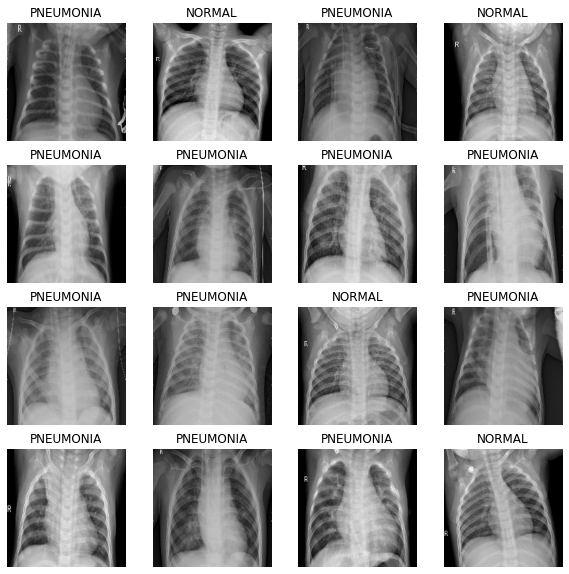

In [29]:
image_batch, label_batch = next(iter(train_ds))

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,4,n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

show_batch(image_batch.numpy(), label_batch.numpy())

### CNN모델링

#### Conv block

In [20]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ]
    )
    
    return block

#### Dense block

In [21]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

### 모델링

In [22]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.3),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.3),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.5),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

### data imbalance 처리
* Weight balancing
  * Weight balancing 은 training set 의 각 데이터에서 loss 를 계산할 때 특정 클래스의 데이터에 더 큰 loss 값을 갖도록 하는 방법
    * 1) 더 큰 정확도를 요구하는 클래스에 가중치를 크게 줌
    * 2) 비율에 따라 적은 샘플수를 가진 클래스에 큰 가중치를 부여

In [23]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.93
Weight for class 1: 0.67


### 모델 컴파일

In [24]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

### 모델 훈련

In [25]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 13742550451420593884,
 name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 17137976894739823349
 physical_device_desc: "device: XLA_CPU device",
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 7542958976
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 17302613137655252627
 physical_device_desc: "device: 0, name: GeForce RTX 2070, pci bus id: 0000:01:00.0, compute capability: 7.5",
 name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 4200853890733255356
 physical_device_desc: "device: XLA_GPU device"]

In [26]:
#모델을 fit 해보겠습니다. 각 파라미터에 위에서 선언했었던 변수, 데이터 셋을 가져와서 각각에 맞게 넣어줍니다.

with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/20
261/261 [==============================] - 28s 106ms/step - loss: 0.3718 - accuracy: 0.8333 - precision: 0.9587 - recall: 0.8100 - val_loss: 0.5706 - val_accuracy: 0.7452 - val_precision: 0.7452 - val_recall: 1.0000
Epoch 2/20
261/261 [==============================] - 24s 92ms/step - loss: 0.2560 - accuracy: 0.9013 - precision: 0.9732 - recall: 0.8915 - val_loss: 0.7301 - val_accuracy: 0.7452 - val_precision: 0.7452 - val_recall: 1.0000
Epoch 3/20
261/261 [==============================] - 24s 91ms/step - loss: 0.2101 - accuracy: 0.9195 - precision: 0.9726 - recall: 0.9172 - val_loss: 0.3942 - val_accuracy: 0.7894 - val_precision: 0.7800 - val_recall: 0.9987
Epoch 4/20
261/261 [==============================] - 24s 91ms/step - loss: 0.1784 - accuracy: 0.9356 - precision: 0.9803 - recall: 0.9318 - val_loss: 0.2189 - val_accuracy: 0.8971 - val_precision: 0.8815 - val_recall: 0.9961
Epoch 5/20
261/261 [==============================] - 24s 91ms/step - loss: 0.1712 - accuracy: 

### 결과 확인

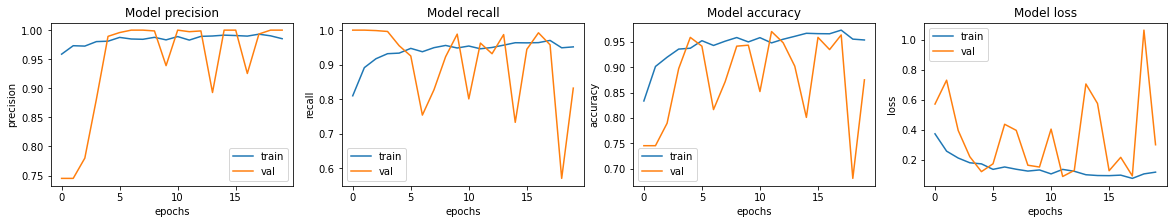

In [27]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

### 모델 평가

In [28]:
loss, acc, prec, rec = model.evaluate(test_ds)

39/39 [==============================] - 2s 59ms/step - loss: 0.4139 - accuracy: 0.8590 - precision: 0.8872 - recall: 0.8872


## 회고


* 이번 노드는 이미지를 학습하여 해당 이미지에 질병이 있는지를 판단하는 노드였습니다. 폐렴 이미지 사진을 학습하여 정확도 85%의 모델을 만들기 위해 여러 하이퍼 파라미터들을 수정해 보았습니다.


* 우선 데이터에 따라 학습의 결과와 조절해야 할 hyper params가 달라지는데, 일반 train_test_split 함수를 사용하면 추출하는 데이터가 지속적으로 달라져 이를 해결하기 위해 random_state를 사용하여 추출하여 분리하는 case를 고정하였습니다. 이로 인해 항상 같은 데이터로 학습을 시킬 수 있게 되었습니다.
  * 실행함에 있어 랜덤값을 취하기 때문에 경미한 수치의 변동은 있습니다
  
  
* 다음으로 예제에 기본적으로 주어진 hyper params로 학습을 시켜 결과를 보았습니다. random_state 1000으로 지정한 첫 validation accuracy는 85.10이었습니다. 


* 학습의 문제점을 찾기 위해 마지막 그래프를 시각화하여 확인하였습니다. accuracy 그래프를 보아 25회학습시 20회 부근에서 train accuracy는 증가하지만 validation accuracy는 감소한다는 것을 알 수 있었습니다. 이는 over fitting으로 판단하여 epoch를 20회로 줄여보았습니다. 이에 accuracy가 85.10에서 87.5로 증가하였습니다. 줄였음에도 마지막에 accuracy가 감소하여, 15회까지 줄여보니 validation accuracy는 증가하고 loss는 감소하였으나 test set으로 평가한 test accuracy는 다시 80으로 감소하였습니다. over fitting이 일어난듯하여 accuracy는 20회로 고정하였습니다.


* batch size는 기존 16에서 8로 줄였을 때 val_acc는 80, 32로 늘렸을 때 66.83으로 기존 16의 성능이 좋았습니다.


* 일반적으로 BN과 dropout은 함께 사용하지 않는다고 알고 있습니다. 따라서 dense layer의 dropout을 제거해 보았습니다. 기존의 87.5에서 75.96으로 감소하였습니다. convolution block에 dropout(0.3)을 추가해보니 성능이 76.76으로 감소하였습니다. dense block의 dropout을 0.5, 0.5, 0.3으로 고정하니 accuracy가 88.9까지 올라갔습니다.


* 이 밖에도 레이어의 구조를 추가해보고 BN, Dropout을 추가해보기도 했지만 성능에 향상은 없었습니다.


#### 느낀점

* 항상 느끼는 것이지만 데이터에 대한 정확한 이해없이 하이퍼 파라미터를 수정해 가는것은 손으로 더듬어가며 입구를 찾는 느낌입니다. 수치를 올려보고, 내려보고를 반복해서 성능이 높아지는 방향으로 나아가는 것이기 때문입니다. 의료분야의 이미지를 딥러닝에 적용해 볼 수 있어서 새로운 경험이었고 이런식으로도 활용할 수 있다는 것을 알게되었습니다.